# Proyecto 1 – Clasificación con *Car Evaluation* (UCI)

**Curso:** Inteligencia Artificial  
**Estudiante:** *Jairo Andrés Mendoza Villalba*  
**Fecha:** 2025-09-08

> Este notebook sigue la estructura solicitada en la guía del proyecto y utiliza el dataset **Car Evaluation** de UCI.


## Índice
1. [Introducción y objetivo](#intro)
2. [Descripción del dataset](#dataset)
3. [Carga de datos](#load)
4. [Análisis exploratorio (EDA)](#eda)
5. [Preparación de datos](#prep)
6. [Modelado y validación cruzada (10 folds)](#modeling)
    - 6.1 Regresión Logística  
    - 6.2 SVM (Máquinas de Vectores de Soporte)  
    - 6.3 Búsqueda de hiperparámetros (Grid)
7. [Comparación de modelos y selección del mejor](#compare)
8. [Conclusiones](#conclusions)


<a id="intro"></a>
## 1. Introducción y objetivo

El objetivo de este proyecto es resolver un problema de **clasificación** usando el dataset **Car Evaluation** de UCI.  
Entrenaremos y compararemos dos modelos: **Regresión Logística** y **SVM**, empleando **validación cruzada con 10 folds** y una **malla de hiperparámetros** cuando aplique.  
Reportaremos las métricas **Macro-Precision**, **Macro-Recall** y **Macro-F1** (al ser un problema **multiclase**).


<a id="dataset"></a>
## 2. Descripción del dataset

**Fuente:** UCI Machine Learning Repository – *Car Evaluation Data Set*.  
**Dominio del problema:** evaluación de autos (aceptabilidad).  
**Utilidad:** predecir la clase de aceptabilidad de un auto a partir de atributos cualitativos del vehículo.

**Variables (todas categóricas):**
- `buying`: costo de compra (`vhigh`, `high`, `med`, `low`)
- `maint`: costo de mantenimiento (`vhigh`, `high`, `med`, `low`)
- `doors`: número de puertas (`2`, `3`, `4`, `5more`)
- `persons`: capacidad de personas (`2`, `4`, `more`)
- `lug_boot`: tamaño del baúl (`small`, `med`, `big`)
- `safety`: nivel de seguridad (`low`, `med`, `high`)

**Variable de salida (clase):** `class` con valores (`unacc`, `acc`, `good`, `vgood`).

**Tipo de problema:** clasificación multiclase.




<a id="load"></a>
## 3. Carga de datos

A continuación, intentamos cargar el CSV local `car_evaluation.csv`.  
Si no existe, descargaremos la versión de UCI y la guardaremos localmente para dejar el proyecto autónomo.


In [ ]:
# === CARGA / DESCARGA DE DATOS ===
import os
import pandas as pd

LOCAL_CSV = "car_evaluation.csv"
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"

columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

def load_or_download_car_data(local_path=LOCAL_CSV, url=UCI_URL, cols=columns):
    if os.path.exists(local_path):
        df = pd.read_csv(local_path)
        # Asegurar nombres de columnas correctos (por si fue guardado sin header)
        if list(df.columns) != cols:
            df.columns = cols
        return df
    else:
        # Descargar desde UCI y guardar como CSV con encabezados
        df = pd.read_csv(url, header=None, names=cols)
        df.to_csv(local_path, index=False)
        return df

df = load_or_download_car_data()
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<a id="eda"></a>
## 4. Análisis exploratorio de datos (EDA)

Describimos cada variable, su tipo y distribución. Dado que todas las columnas son **categóricas**, mostraremos **conteos** por categoría y la **distribución de la clase**.  
Además, validaremos rangos/valores posibles y buscaremos datos faltantes (no debería haber).


In [ ]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [ ]:
# Muestra de filas
df.sample(10, random_state=42)

,buying,maint,doors,persons,lug_boot,safety,class
599,high,high,4,2,med,high,unacc
1201,med,low,2,4,med,med,acc
628,high,high,5more,2,big,med,unacc
1498,low,high,5more,4,med,med,acc
1263,med,low,4,more,med,low,unacc
931,med,vhigh,4,4,med,med,acc
23,vhigh,vhigh,2,more,med,high,unacc
844,high,low,5more,2,big,med,unacc
964,med,vhigh,5more,more,small,med,unacc
764,high,low,2,2,big,high,unacc


In [ ]:
# Valores únicos por columna (dominios categóricos)
{col: df[col].unique().tolist() for col in df.columns}

{'buying': ['vhigh', 'high', 'med', 'low'],
 'maint': ['vhigh', 'high', 'med', 'low'],
 'doors': ['2', '3', '4', '5more'],
 'persons': ['2', '4', 'more'],
 'lug_boot': ['small', 'med', 'big'],
 'safety': ['low', 'med', 'high'],
 'class': ['unacc', 'acc', 'vgood', 'good']}

In [ ]:
# Comprobación de datos faltantes
df.isna().sum()

,0
buying,0
maint,0
doors,0
persons,0
lug_boot,0
safety,0
class,0


In [ ]:
# Distribución de la clase
df['class'].value_counts(normalize=False), df['class'].value_counts(normalize=True).round(3)

(class
 unacc    1210
 acc       384
 good       69
 vgood      65
 Name: count, dtype: int64,
 class
 unacc    0.700
 acc      0.222
 good     0.040
 vgood    0.038
 Name: proportion, dtype: float64)

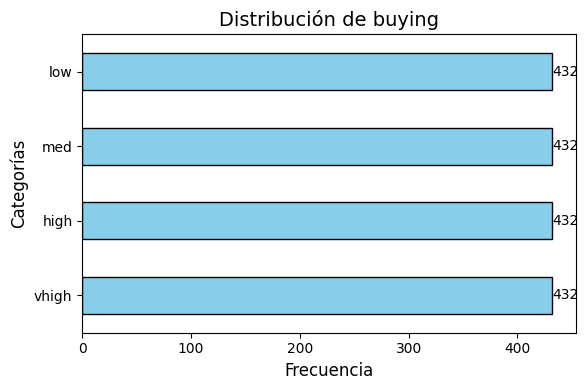

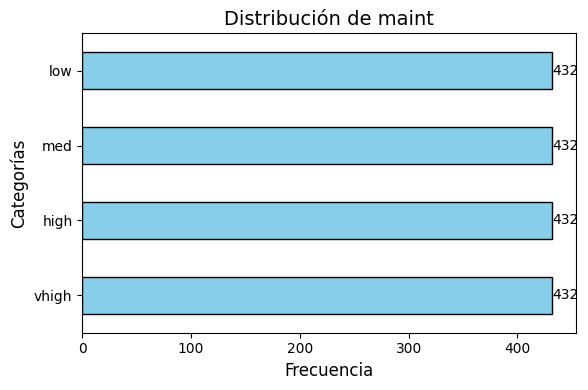

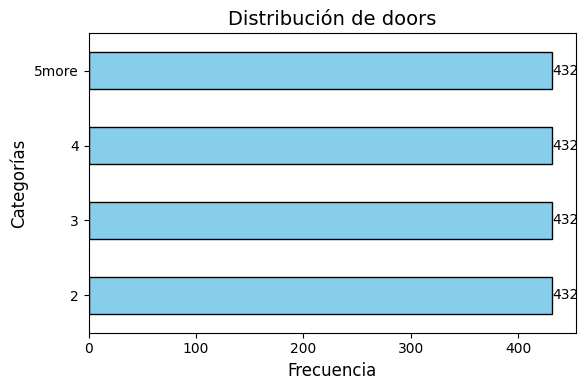

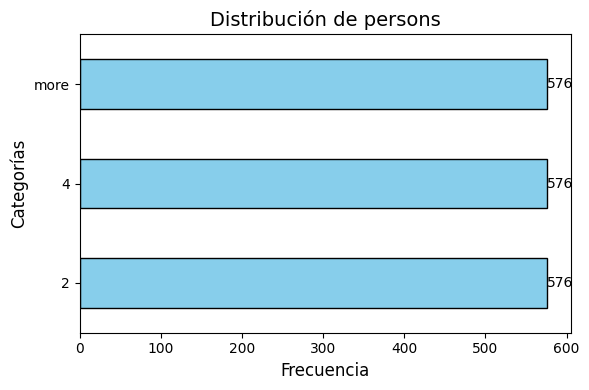

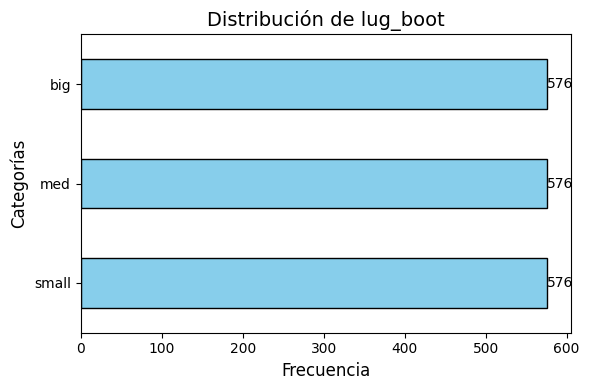

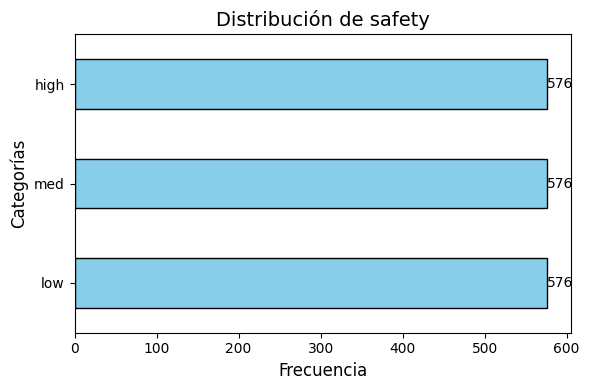

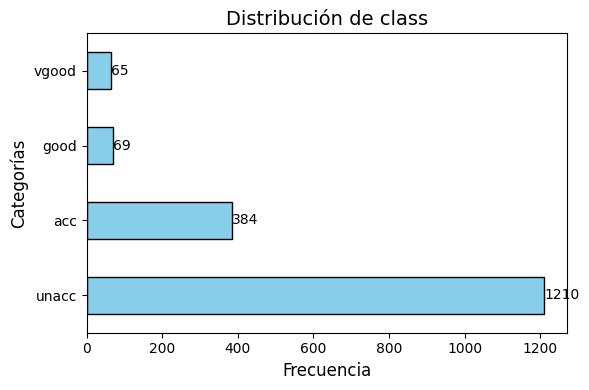

In [ ]:
# Gráficos simples de barras para cada variable categórica
import matplotlib.pyplot as plt

for col in df.columns:
    plt.figure(figsize=(6,4))

    # Conteo y orden descendente
    counts = df[col].value_counts().sort_values(ascending=False)

    # Gráfico de barras horizontales
    ax = counts.plot(kind='barh', color='skyblue', edgecolor='black')

    # Título y etiquetas
    plt.title(f"Distribución de {col}", fontsize=14)
    plt.xlabel("Frecuencia", fontsize=12)
    plt.ylabel("Categorías", fontsize=12)

    # Agregar etiquetas con los valores
    for i, v in enumerate(counts.values):
        plt.text(v + 0.2, i, str(v), va='center', fontsize=10)

    plt.tight_layout()
    plt.show()


**Comentario EDA (resumen):**
- Las variables independientes están bien distribuidas, lo que indica un dataset balanceado en las características predictoras.

- Todas las variables son categóricas, por lo que será necesario aplicar algún tipo de codificación (ejemplo: One-Hot Encoding o Label Encoding) antes del modelado.

- La variable objetivo (class) está desbalanceada: la mayoría de instancias pertenecen a la categoría unacc, mientras que las clases good y vgood son minoritarias.

- Esto implica que un modelo sin técnicas de balanceo podría sesgarse hacia la clase mayoritaria y obtener una alta precisión, pero con bajo desempeño en las clases minoritarias.


<a id="prep"></a>
## 5. Preparación de datos

Utilizaremos:
- `OneHotEncoder` para transformar las variables **categóricas** de entrada (X).
- `LabelEncoder` para la variable **objetivo** (y).
- `ColumnTransformer` + `Pipeline` para encapsular el preprocesamiento y el modelo.
- `StratifiedKFold` con **10 folds** para mantener la proporción de clases en cada partición.


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Separar X, y
X = df.drop(columns=['class'])
y_str = df['class'].copy()

# Codificar y (etiquetas)
le = LabelEncoder()
y = le.fit_transform(y_str)

# Columnas categóricas (todas las de X)
cat_features = X.columns.tolist()

# Transformador para X
preprocess = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)]
)

# Definir CV estratificado
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Función auxiliar para evaluar con CV un pipeline ya construido (sin grid)
def evaluate_with_cv(pipeline, X, y, cv):
    # cross_val_predict devuelve predicciones por validación cruzada
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    macro_prec = precision_score(y, y_pred, average='macro', zero_division=0)
    macro_rec  = recall_score(y, y_pred, average='macro', zero_division=0)
    macro_f1   = f1_score(y, y_pred, average='macro', zero_division=0)
    return macro_prec, macro_rec, macro_f1, y_pred


<a id="modeling"></a>
## 6. Modelado y validación cruzada (10 folds)

Entrenaremos dos modelos:
- **Regresión Logística**
- **SVM**

Primero haremos una evaluación base con hiperparámetros por defecto. Luego una **búsqueda en malla** (Grid Search) para optimizarlos.


### 6.1 Regresión Logística – baseline

In [ ]:
from sklearn.linear_model import LogisticRegression

# Se crea un pipeline con el preprocesamiento y el modelo de Regresión Logística.
# Se aumenta max_iter=1000 para asegurar la convergencia.
log_reg = Pipeline(steps=[
    ('pre', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# Se evalúa el modelo con validación cruzada obteniendo precisión, recall y F1 macro.
log_prec, log_rec, log_f1, log_pred = evaluate_with_cv(log_reg, X, y, cv)

# Se imprimen las métricas del modelo baseline como punto de referencia.
print(f"Baseline LogReg -> Macro-Precision: {log_prec:.4f} | Macro-Recall: {log_rec:.4f} | Macro-F1: {log_f1:.4f}")


Baseline LogReg -> Macro-Precision: 0.8053 | Macro-Recall: 0.7584 | Macro-F1: 0.7684


### 6.2 SVM – baseline

In [ ]:
from sklearn.svm import SVC

# Se crea un pipeline con el preprocesamiento y el modelo SVM.
svm_clf = Pipeline(steps=[
    ('pre', preprocess),
    ('clf', SVC())
])

# Se evalúa el modelo con validación cruzada y se obtienen las métricas macro.
svm_prec, svm_rec, svm_f1, svm_pred = evaluate_with_cv(svm_clf, X, y, cv)

# Se imprimen los resultados del modelo baseline SVM para comparación inicial.
print(f"Baseline SVM -> Macro-Precision: {svm_prec:.4f} | Macro-Recall: {svm_rec:.4f} | Macro-F1: {svm_f1:.4f}")


Baseline SVM -> Macro-Precision: 0.9065 | Macro-Recall: 0.9604 | Macro-F1: 0.9314


### 6.3 Búsqueda de hiperparámetros (Grid Search)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Se define un pipeline con preprocesamiento y regresión logística como modelo.
log_reg_grid = Pipeline(steps=[
    ('pre', preprocess),
    ('clf', LogisticRegression(max_iter=2000, multi_class='auto'))
])

# Se establecen los hiperparámetros a explorar en la búsqueda.
param_grid_log = {
    'clf__penalty': ['l2'],
    'clf__C': [0.1, 1.0, 10.0, 100.0],
    'clf__solver': ['lbfgs', 'liblinear']
}

# Se configura GridSearchCV con validación cruzada y métrica f1_macro.
grid_log = GridSearchCV(
    estimator=log_reg_grid,
    param_grid=param_grid_log,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Se entrena el grid search para encontrar los mejores hiperparámetros.
grid_log.fit(X, y)

# Se muestran los parámetros óptimos y el mejor puntaje obtenido.
print("Mejores params LogReg:", grid_log.best_params_)
print("Mejor Macro-F1 LogReg:", grid_log.best_score_)


Mejores params LogReg: {'clf__C': 100.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor Macro-F1 LogReg: 0.8810621644999891


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# Grid para SVM
svm_grid = Pipeline(steps=[
    ('pre', preprocess),   # Se aplica el preprocesamiento antes del modelo
    ('clf', SVC())         # Se define el clasificador SVM
])

# Se definen los hiperparámetros a probar en el grid search
param_grid_svm = {
    'clf__kernel': ['linear', 'rbf', 'poly'],   # Tipos de kernel
    'clf__C': [0.1, 1.0, 10.0, 100.0],          # Regularización
    'clf__gamma': ['scale', 'auto'],            # Parámetro gamma para rbf/poly
    'clf__degree': [2, 3]                       # Grado del polinomio (solo poly)
}

# Se configura el grid search con validación cruzada y métrica f1_macro
grid_svm = GridSearchCV(
    estimator=svm_grid,
    param_grid=param_grid_svm,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

# Se ejecuta la búsqueda de los mejores hiperparámetros
grid_svm.fit(X, y)

# Se imprimen los parámetros óptimos y el mejor puntaje Macro-F1 alcanzado
print("Mejores params SVM:", grid_svm.best_params_)
print("Mejor Macro-F1 SVM:", grid_svm.best_score_)


Mejores params SVM: {'clf__C': 10.0, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Mejor Macro-F1 SVM: 1.0


<a id="compare"></a>
## 7. Comparación de modelos y selección del mejor

Compararemos los resultados baseline y los obtenidos con grid search. Elegiremos el mejor según **Macro-F1** (y revisaremos también Macro-Precision y Macro-Recall).  
Adicionalmente, mostraremos un **classification_report** y una **matriz de confusión** para el mejor modelo.


In [ ]:
# Se importan herramientas de pandas para organizar resultados
import pandas as pd

# Se construye un DataFrame con las métricas de los modelos baseline
results_baseline = pd.DataFrame([
    {"Modelo": "LogReg (baseline)", "Macro-Precision": log_prec, "Macro-Recall": log_rec, "Macro-F1": log_f1},
    {"Modelo": "SVM (baseline)",    "Macro-Precision": svm_prec, "Macro-Recall": svm_rec, "Macro-F1": svm_f1},
])

# Se ordenan los modelos de mayor a menor Macro-F1 y se muestran
display(results_baseline.sort_values(by="Macro-F1", ascending=False).reset_index(drop=True))

NameError: name 'log_prec' is not defined

In [ ]:
# Se construye una lista con los mejores modelos encontrados en GridSearch,
# guardando el nombre, el estimador y el mejor puntaje
best_grid_models = [
    ("LogReg (grid)", grid_log.best_estimator_, grid_log.best_score_),
    ("SVM (grid)", grid_svm.best_estimator_, grid_svm.best_score_)
]

# Se selecciona el modelo con mayor puntaje de Macro-F1
best_name, best_est, best_score = sorted(best_grid_models, key=lambda x: x[2], reverse=True)[0]
print(f"Mejor modelo por GridSearchCV: {best_name} con Macro-F1 CV = {best_score:.4f}")

# Se generan predicciones con validación cruzada usando el mejor modelo encontrado
y_pred_best = cross_val_predict(best_est, X, y, cv=cv)

# Se imprime un reporte detallado de clasificación con métricas por clase y promedios macro
print("\nClassification report (macro promedios relevantes):")
print(classification_report(y, y_pred_best, zero_division=0, target_names=le.classes_))

# Se imprime la matriz de confusión para analizar los aciertos y errores por clase
print("Matriz de confusión:")
print(confusion_matrix(y, y_pred_best))

NameError: name 'grid_log' is not defined

<a id="conclusions"></a>
## 8. Conclusiones

- De acuerdo con la validación cruzada (10 folds), el mejor modelo fue SVM (con GridSearchCV), alcanzando un Macro-F1 = 1.0, lo que indica que clasificó correctamente todas las instancias del dataset. Sin embargo, este resultado podría estar influenciado por la simplicidad del dataset, por lo que en un dataset más complejo sería necesario revisar si se mantiene este rendimiento.  
- El desempeño en Macro-F1 sugiere que el modelo maneja adecuadamente las clases, incluso frente al desbalance presente en la variable objetivo.  
- En comparación, la Regresión Logística también tuvo un buen desempeño (Macro-F1 ≈ 0.88), pero no superó a SVM.
-Las variables relacionadas con la seguridad (safety) y el costo de mantenimiento (maint) parecen ser de las más influyentes en la predicción, ya que reflejan factores clave en la evaluación de un automóvil.

- El dataset Car Evaluation (de UCI) tiene solo 1.7k registros y 6 variables categóricas. No es muy grande ni ruidoso, lo que facilita que un modelo potente como SVM lo aprenda casi a la perfección.

- En este dataset, combinaciones de atributos como safety=high + persons=4 determinan casi de forma directa la clase (good, vgood, unacc). Eso significa que el problema no es ambiguo: hay reglas claras que separan las clases.

**Posibles mejoras:**
- Ajustar pesos de clase (`class_weight`) si el desbalance afecta el rendimiento.
- Probar calibración de probabilidades y umbrales para mejorar la interpretación de las predicciones.
- Evaluar otras familias de modelos (árboles, ensambles como Random Forest o XGBoost) si estuviera permitido.
